In [1]:
import sqlite3
import pandas as pd
import os
import re
import numpy as np
#import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize, StanfordTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import string
import entropy
%matplotlib inline 
#from textstat.textstat import textstat
sns.set_style("whitegrid")
os.chdir('/Users/RayLJazz//Dropbox/UCDavis/2016spring/STA208/Final/Data')

# Read sql data

In [2]:
query = "SELECT * FROM [posts]"
conn = sqlite3.connect('crossvalidated.db')
post_df = pd.read_sql_query(query, conn)
post_df.head()
qpost_df = post_df[post_df.PostTypeId == 1]

In [3]:
qpost_df['Body'].shape

(75067,)

## Clean body
Remove:

1.Code lines 

2.links 

3.Emails 

4.Formulas

5.\newline, \tab

In [4]:
#Body_clean_puc= pd.read_pickle('Body_clean_puc.pickle')
def exact_from_html(row, puc=0):
    soup = BeautifulSoup(row, "html.parser")

    #remove code
    #chunck_num = len(soup.find_all('code'))
    #i=1
    #while True:
      #  if i <= chunck_num:
            #soup.code.extract()
            #i = i + 1
        #else:
            #break
    for tag in soup.find_all('code'):
        tag.replaceWith(' ')
    ######
    raw = soup.get_text()
    #remove link
    raw_no_link = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", '', raw)
    #remove email
    no_link_email = re.sub(r'[\w\.-]+@[\w\.-]+[\.][com|org|ch|uk]{2,3}', "", raw_no_link)
    #remove whitespace
    tab_text = '\t\n\r\x0b\x0c'
    no_link_email_space = "".join([ch for ch in no_link_email if ch not in set(tab_text)])
    #remove fomula
    reg = '(\$.+?\$)|((\\\\begin\{.+?\})(.+?)(\\\\end\{(.+?)\}))'
    raw = re.sub(reg, "", no_link_email_space, flags=re.IGNORECASE)
    #remove numbers
    raw = re.sub('[0-9]+?', ' ', raw)
    #remove punctuation
    #if puc == 1:
     #   raw = "".join([ch for ch in raw if ch not in set(string.punctuation)])
    # remove stop words
    #raw = " ".join([word for word in word_tokenize(raw.lower()) if word not in stopwords.words('english')])
    return(raw)

In [5]:
fun_clean = lambda i: exact_from_html(i)
Body_clean_puc = qpost_df['Body'].map(fun_clean)

In [6]:
Body_clean_puc.head()

0    How should I elicit prior distributions from e...
1    In many different statistical methods there is...
2    What are some valuable Statistical Analysis op...
3    I have two groups of data.  Each with a differ...
5    Last year, I read a blog post from Brendan O'C...
Name: Body, dtype: object

In [7]:
import pickle
with open('Body_clean_puc.pickle', 'wb') as handle:
    pickle.dump(Body_clean_puc, handle,protocol=2)

## Exact code and formula

In [8]:
fomula_num = []
Code = []
def exact_formula(row):
    soup = BeautifulSoup(row, "html.parser")
    #remove code
    chunck_num = len(soup.find_all('code'))
    i=1
    while True:
        if chunck_num == 0:
            Code.append(0)
            break
        elif i <= chunck_num:
            code_num = 0
            code = soup.code.get_text()
            code = code.split('\n')
            codes = [x for x in code if x != '']
            code_num = code_num + len(codes)
            soup.code.extract()
            i = i + 1
        else:
            Code.append(code_num)
            break

    ######
    raw = soup.get_text()
    #remove link
    raw_no_link = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", '', raw)
    #remove email
    no_link_email = re.sub(r'[\w\.-]+@[\w\.-]+[\.][com|org|ch|uk]{2,3}', "", raw_no_link)
    #remove whitespace
    tab_text = '\t\n\r\x0b\x0c'
    no_link_email_space = "".join([ch for ch in no_link_email if ch not in set(tab_text)])
    # remove fomula
    reg = '(\$.+?\$)|((\\\\begin\{.+?\})(.+?)(\\\\end\{(.+?)\}))'
    re_fomula = re.findall(reg, no_link_email_space, flags=re.IGNORECASE)
    if re_fomula != []:
        for item in re_fomula:
            no_link_email_space = no_link_email_space.replace(str(item), '')
        fomula_num.append(int(1))
    else:
        fomula_num.append(int(0))

In [9]:
fun_clean = lambda i: exact_formula(i)
get_result = qpost_df['Body'].map(fun_clean)

In [10]:
Code_df = pd.Series(data=Code)
Code_df.describe()
#Code_df.value_counts()

count    75067.000000
mean         2.250110
std         16.899923
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       2160.000000
dtype: float64

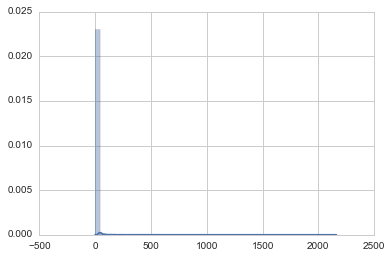

In [11]:
sns.distplot(Code_df, rug=False)

In [12]:
fomula_num_df = pd.Series(data=fomula_num)
fomula_num_df.value_counts()

0    54362
1    20705
dtype: int64

In [13]:
Body_clean_puc_df = pd.DataFrame(Body_clean_puc)
Body_clean_puc_df['Code number'] = Code_df
Body_clean_puc_df['formula'] = fomula_num_df
Body_clean_puc_df.head()

,Body,Code number,formula
0,How should I elicit prior distributions from e...,0.0,0.0
1,In many different statistical methods there is...,0.0,0.0
2,What are some valuable Statistical Analysis op...,0.0,0.0
3,I have two groups of data. Each with a differ...,0.0,0.0
5,"Last year, I read a blog post from Brendan O'C...",0.0,0.0


In [14]:
#Body_clean_puc_df[Body_clean_puc_df['Code number']>50]

In [15]:
qpost_df['Code number'] = Code_df
qpost_df['formula'] = fomula_num_df
qpost_df.head()

/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Body,ViewCount,LastEditorDisplayName,ClosedDate,CommunityOwnedDate,LastEditorUserId,ParentID,LastEditDate,CommentCount,AnswerCount,...,Title,PostTypeId,OwnerUserId,Tags,CreationDate,FavoriteCount,Id,LastActivityDate,Code number,formula
0,<p>How should I elicit prior distributions fro...,1850.0,None,None,None,NaN,NaN,None,1,5.0,...,Eliciting priors from experts,1,8.0,<bayesian><prior><elicitation>,2010-07-19T19:12:12.510,19.0,1,2010-09-15T21:08:26.077,0.0,0.0
1,<p>In many different statistical methods there...,15519.0,None,None,None,88.0,NaN,2010-08-07T17:56:44.800,1,7.0,...,What is normality?,1,24.0,<distributions><normality>,2010-07-19T19:12:57.157,9.0,2,2012-11-12T09:21:54.993,0.0,0.0
2,<p>What are some valuable Statistical Analysis...,5162.0,None,None,2010-07-19T19:13:28.577,183.0,NaN,2011-02-12T05:50:03.667,4,19.0,...,What are some valuable Statistical Analysis op...,1,18.0,<software><open-source>,2010-07-19T19:13:28.577,38.0,3,2013-05-27T14:48:36.927,0.0,0.0
3,<p>I have two groups of data. Each with a dif...,15443.0,None,None,None,NaN,NaN,None,2,5.0,...,Assessing the significance of differences in d...,1,23.0,<distributions><statistical-significance>,2010-07-19T19:13:31.617,4.0,4,2010-09-08T03:00:19.690,0.0,0.0
5,"<p>Last year, I read a blog post from <a href=...",65657.0,None,None,2010-08-09T13:05:50.603,22047.0,NaN,2013-06-07T06:38:10.327,6,17.0,...,The Two Cultures: statistics vs. machine learn...,1,5.0,<machine-learning>,2010-07-19T19:14:44.080,211.0,6,2015-03-18T12:14:33.740,0.0,0.0


In [16]:
test_data = Body_clean_puc[1]

In [17]:
test_data

u'In many different statistical methods there is an "assumption of normality".  What is "normality" and how do I know if there is normality?'

# Readablity Function--Base

## Words count

In [18]:
# words count
def word_num(text):
    text = "".join(x for x in text if x not in list(set(string.punctuation)))
    text = word_tokenize(text)
    return (len(text))

In [19]:
word_num(test_data)

23

In [20]:
Words_num = Body_clean_puc_df['Body'].apply(word_num)
Words_num_df = pd.Series(data=Words_num)
Words_num_df.value_counts().head()

68    552
65    545
51    545
62    543
69    539
Name: Body, dtype: int64

## Sentence count

In [21]:
# sentence count
def sent_num(text):
    return (len(sent_tokenize(text)))

In [22]:
Sents_num = Body_clean_puc_df['Body'].apply(sent_num)
Sents_num_df = pd.Series(data=Sents_num)
Sents_num_df.value_counts().head()

3    10754
4    10176
2     9447
5     8749
6     6880
Name: Body, dtype: int64

## syllables count

In [23]:
# syllables count The "Written Method" Rules:http://www.howmanysyllables.com/howtocountsyllables
def syllable_num(text):
    count = 0
    vowels = 'aeiouy'
    text = text.lower()
    text = "".join(x for x in text if x not in list(set(string.punctuation)))

    if text == None:
        return 0
    elif len(text) == 0:
        return 0
    else:
        if text[0] in vowels: 
            count += 1
        for index in range(1, len(text)):
            if text[index] in vowels and text[index-1] not in vowels:
                count += 1
        if text.endswith('e'): 
            count -= 1
        if text.endswith('le'):
            count += 1
        if text.endswith('les'):
            count += 1
        if count == 0:
            count += 1
    return count

In [24]:
syllable_num(test_data)

43

## polysyllables count

In [25]:
# polysyllables count
def polysyllab_num(text):
    count = 0
    for word in text.split():
        wrds = syllable_num(word)
        if wrds >= 3:
            count += 1
    return count

In [26]:
polysyllab_num(test_data)

6

## Characters count

In [27]:
# characters count
def char_num(text, ignore_spaces=True):
    if ignore_spaces:
        text = text.replace(" ", "")
    text = "".join(x for x in text if x not in list(set(string.punctuation)))
    return len(text)

In [28]:
char_num(test_data)

109

## Complex words

In [29]:
easy_words = """a able aboard about above absent accept accident account ache aching acorn acre across act acts add address admire adventure afar	afraid after afternoon afterward afterwards again against age aged ago agree ah ahead aid aim air airfield airplane airport airship airy	alarm alike alive all alley alligator allow almost alone along aloud already also always am America American among amount an and	angel anger angry animal another answer ant any anybody anyhow anyone anything anyway anywhere apart apartment ape apiece appear apple April	apron are aren't arise arithmetic arm armful army arose around arrange arrive arrived arrow art artist as ash ashes aside ask	asleep at ate attack attend attention August aunt author auto automobile autumn avenue awake awaken away awful awfully awhile ax axe baa babe babies back background backward backwards bacon bad badge badly bag bake baker bakery baking ball balloon banana band bandage bang banjo bank banker bar barber bare barefoot barely bark barn barrel base baseball basement basket bat batch bath bathe bathing bathroom bathtub	battle battleship bay be beach bead beam bean bear beard beast beat beating beautiful beautify beauty became because become becoming bed bedbug bedroom bedspread bedtime bee beech beef beefsteak beehive been beer beet before beg began beggar begged begin beginning begun behave behind being	believe bell belong below belt bench bend beneath bent berries berry beside besides best bet better between bib bible bicycle bid big bigger bill billboard bin bind bird birth birthday biscuit bit bite biting bitter black blackberry blackbird blackboard blackness blacksmith blame blank blanket	blast blaze bleed bless blessing blew blind blindfold blinds block blood bloom blossom blot blow blue blueberry bluebird blush board boast boat bob bobwhite bodies body boil boiler bold bone bonnet boo book bookcase bookkeeper boom boot born borrow boss both bother bottle bottom	bought bounce bow bowl bow-wow box boxcar boxer boxes boy boyhood bracelet brain brake bran branch brass brave bread break breakfast breast breath breathe breeze brick bride bridge bright brightness bring broad broadcast broke broken brook broom brother brought brown brush bubble bucket buckle	bud buffalo bug buggy build building built bulb bull bullet bum bumblebee bump bun bunch bundle bunny burn burst bury bus bush bushel business busy but butcher butt butter buttercup butterfly buttermilk butterscotch button buttonhole buy buzz by bye cab cabbage cabin cabinet cackle cage cake calendar calf call caller calling came camel camp campfire can canal canary candle candlestick candy cane cannon cannot canoe can't canyon cap cape capital captain car card cardboard care careful careless carelessness carload carpenter carpet carriage carrot carry cart	carve case cash cashier castle cat catbird catch catcher caterpillar catfish catsup cattle caught cause cave ceiling cell cellar cent center cereal certain certainly chain chair chalk champion chance change chap charge charm chart chase chatter cheap cheat check checkers cheek cheer cheese cherry chest chew	chick chicken chief child childhood children chill chilly chimney chin china chip chipmunk chocolate choice choose chop chorus chose chosen christen Christmas church churn cigarette circle circus citizen city clang clap class classmate classroom claw clay clean cleaner clear clerk clever click cliff climb clip cloak	clock close closet cloth clothes clothing cloud cloudy clover clown club cluck clump coach coal coast coat cob cobbler cocoa coconut cocoon cod codfish coffee coffeepot coin cold collar college color colored colt column comb come comfort comic coming company compare conductor cone connect coo cook	cooked cooking cookie cookies cool cooler coop copper copy cord cork corn corner correct cost cot cottage cotton couch cough could couldn't count counter country county course court cousin cover cow coward cowardly cowboy cozy crab crack cracker cradle cramps cranberry crank cranky crash crawl crazy	cream creamy creek creep crept cried croak crook crooked crop cross crossing cross-eyed crow crowd crowded crown cruel crumb crumble crush crust cry cries cub cuff cup cuff cup cupboard cupful cure curl curly curtain curve cushion custard customer cut cute cutting dab dad daddy daily dairy daisy dam damage dame damp dance dancer dancing dandy danger dangerous dare dark darkness darling darn dart dash date daughter	dawn day daybreak daytime dead deaf deal dear death December decide deck deed deep deer defeat defend defense delight den dentist depend deposit describe desert	deserve desire desk destroy devil dew diamond did didn't die died dies difference different dig dim dime dine ding-dong dinner dip direct direction dirt dirty	discover dish dislike dismiss ditch dive diver divide do dock doctor does doesn't dog doll dollar dolly done donkey don't door doorbell doorknob doorstep dope	dot double dough dove down downstairs downtown dozen drag drain drank draw drawer draw drawing dream dress dresser dressmaker drew dried drift drill drink drip	drive driven driver drop drove drown drowsy drub drum drunk dry duck due dug dull dumb dump during dust dusty duty dwarf dwell dwelt dying each eager eagle ear early earn earth east eastern easy eat eaten	edge egg eh eight eighteen eighth eighty either elbow elder eldest electric	electricity elephant eleven elf elm else elsewhere empty end ending enemy engine	engineer English enjoy enough enter envelope equal erase eraser errand escape eve	even evening ever every everybody everyday everyone everything everywhere evil exact except	exchange excited exciting excuse exit expect explain extra eye eyebrow fable face facing fact factory fail faint fair fairy faith fake fall false family fan fancy far faraway fare farmer farm farming far-off farther fashion fast fasten fat father	fault favor favorite fear feast feather February fed feed feel feet fell fellow felt fence fever few fib fiddle field fife fifteen fifth fifty fig fight figure file fill	film finally find fine finger finish fire firearm firecracker fireplace fireworks firing first fish fisherman fist fit fits five fix flag flake flame flap flash flashlight flat flea flesh	flew flies flight flip flip-flop float flock flood floor flop flour flow flower flowery flutter fly foam fog foggy fold folks follow following fond food fool foolish foot football	footprint for forehead forest forget forgive forgot forgotten fork form fort forth fortune forty forward fought found fountain four fourteen fourth fox frame free freedom freeze freight French fresh	fret Friday fried friend friendly friendship frighten frog from front frost frown froze fruit fry fudge fuel full fully fun funny fur furniture further fuzzy gain gallon gallop game gang garage garbage garden gas gasoline gate gather gave gay gear geese general gentle gentleman gentlemen	geography get getting giant gift gingerbread girl give given giving glad gladly glance glass glasses gleam glide glory glove glow	glue go going goes goal goat gobble God god godmother gold golden goldfish golf gone good goods goodbye good-by goodbye	good-bye good-looking goodness goody goose gooseberry got govern government gown grab gracious grade grain grand grandchild grandchildren granddaughter grandfather grandma	grandmother grandpa grandson grandstand grape grapes grapefruit grass grasshopper grateful grave gravel graveyard gravy gray graze grease great green greet	grew grind groan grocery ground group grove grow guard guess guest guide gulf gum gun gunpowder guy ha habit had hadn't hail hair haircut hairpin half hall halt ham hammer hand handful handkerchief handle handwriting hang happen happily happiness happy harbor hard hardly hardship hardware hare hark	harm harness harp harvest has hasn't haste hasten hasty hat hatch hatchet hate haul have haven't having hawk hay hayfield haystack he head headache heal health healthy heap hear hearing	heard heart heat heater heaven heavy he'd heel height held hell he'll hello helmet help helper helpful hem hen henhouse her hers herd here here's hero herself he's hey hickory	hid hidden hide high highway hill hillside hilltop hilly him himself hind hint hip hire his hiss history hit hitch hive ho hoe hog hold holder hole holiday hollow holy	home homely homesick honest honey honeybee honeymoon honk honor hood hoof hook hoop hop hope hopeful hopeless horn horse horseback horseshoe hose hospital host hot hotel hound hour house housetop	housewife housework how however howl hug huge hum humble hump hundred hung hunger hungry hunk hunt hunter hurrah hurried hurry hurt husband hush hut hymn I ice icy I'd idea ideal if ill	I'll I'm important impossible improve in inch inches	income indeed Indian indoors ink inn insect inside	instant instead insult intend interested interesting into invite	iron is island isn't it its it's itself	I've ivory ivy jacket jacks jail jam January jar	jaw jay jelly jellyfish jerk jig	job jockey join joke joking jolly	journey joy joyful joyous judge jug	juice juicy July jump June junior	junk just keen keep kept kettle key	kick kid kill killed kind	kindly kindness king kingdom kiss	kitchen kite kitten kitty knee	kneel knew knife knit knives	knob knock knot know known lace lad ladder ladies lady laid lake lamb lame lamp land lane language lantern lap lard large lash lass last	late laugh laundry law lawn lawyer lay lazy lead leader leaf leak lean leap learn learned least leather leave leaving	led left leg lemon lemonade lend length less lesson let let's letter letting lettuce level liberty library lice lick lid	lie life lift light lightness lightning like likely liking lily limb lime limp line linen lion lip list listen lit	little live lives lively liver living lizard load loaf loan loaves lock locomotive log lone lonely lonesome long look lookout	loop loose lord lose loser loss lost lot loud love lovely lover low luck lucky lumber lump lunch lying machine machinery mad made magazine magic maid mail mailbox mailman major make making male mama mamma man manager mane manger many map	maple marble march March mare mark market marriage married marry mask mast master mat match matter mattress may May maybe mayor maypole me	meadow meal mean means meant measure meat medicine meet meeting melt member men mend meow merry mess message met metal mew mice middle	midnight might mighty mile milk milkman mill miler million mind mine miner mint minute mirror mischief miss Miss misspell mistake misty mitt mitten	mix moment Monday money monkey month moo moon moonlight moose mop more morning morrow moss most mostly mother motor mount mountain mouse mouth	move movie movies moving mow Mr. Mrs. much mud muddy mug mule multiply murder music must my myself nail name nap napkin narrow nasty naughty navy near nearby	nearly neat neck necktie need needle needn't Negro neighbor neighborhood	neither nerve nest net never nevermore new news newspaper next	nibble nice nickel night nightgown nine nineteen ninety no nobody	nod noise noisy none noon nor north northern nose not	note nothing notice November now nowhere number nurse nut oak oar oatmeal oats obey ocean o'clock October odd of off	offer office officer often oh oil old old-fashioned on once one	onion only onward open or orange orchard order ore organ other	otherwise ouch ought our ours ourselves out outdoors outfit outlaw outline	outside outward oven over overalls overcoat overeat overhead overhear overnight overturn	owe owing owl own owner ox pa pace pack package pad page paid pail pain painful paint painter painting pair pal palace pale pan pancake pane pansy pants papa paper parade pardon parent park part partly partner party	pass passenger past paste pasture pat patch path patter pave pavement paw pay payment pea peas peace peaceful peach peaches peak peanut pear pearl peck peek peel peep peg pen pencil penny	people pepper peppermint perfume perhaps person pet phone piano pick pickle picnic picture pie piece pig pigeon piggy pile pill pillow pin pine pineapple pink pint pipe pistol pit pitch pitcher pity	place plain plan plane plant plate platform platter play player playground playhouse playmate plaything pleasant please pleasure plenty plow plug plum pocket pocketbook poem point poison poke pole police policeman polish polite	pond ponies pony pool poor pop popcorn popped porch pork possible post postage postman pot potato potatoes pound pour powder power powerful praise pray prayer prepare present pretty price prick prince princess	print prison prize promise proper protect proud prove prune public puddle puff pull pump pumpkin punch punish pup pupil puppy pure purple purse push puss pussy pussycat put putting puzzle quack quart	quarter queen	queer question	quick quickly	quiet quilt	quit quite rabbit race rack radio radish rag rail railroad railway rain rainy rainbow raise raisin rake ram ran ranch rang rap rapidly	rat rate rather rattle raw ray reach read reader reading ready real really reap rear reason rebuild receive recess record red	redbird redbreast refuse reindeer rejoice remain remember remind remove rent repair repay repeat report rest return review reward rib ribbon rice	rich rid riddle ride rider riding right rim ring rip ripe rise rising river road roadside roar roast rob robber robe	robin rock rocky rocket rode roll roller roof room rooster root rope rose rosebud rot rotten rough round route row rowboat	royal rub rubbed rubber rubbish rug rule ruler rumble run rung runner running rush rust rusty rye sack sad saddle sadness safe safety said sail sailboat sailor saint salad sale salt same sand sandy sandwich sang sank sap sash sat satin satisfactory Saturday sausage savage save savings saw say scab scales scare scarf school schoolboy schoolhouse schoolmaster schoolroom scorch score scrap scrape scratch scream screen screw scrub sea seal seam search season seat second secret see seeing seed seek seem seen seesaw select self selfish	sell send sense sent sentence separate September servant serve service set setting settle settlement seven seventeen seventh seventy several sew shade shadow shady shake shaker shaking shall shame shan't shape share sharp shave she she'd she'll she's shear shears shed sheep sheet shelf shell shepherd shine shining shiny ship shirt shock shoe shoemaker shone shook shoot shop shopping shore short shot should shoulder shouldn't shout shovel show shower	shut shy sick sickness side sidewalk sideways sigh sight sign silence silent silk sill silly silver simple sin since sing singer single sink sip sir sis sissy sister sit sitting six sixteen sixth sixty size skate skater ski skin skip skirt sky slam slap slate slave sled sleep sleepy sleeve sleigh slept slice slid slide sling slip slipped slipper slippery slit slow slowly sly smack small smart smell	smile smoke smooth snail snake snap snapping sneeze snow snowy snowball snowflake snuff snug so soak soap sob socks sod soda sofa soft soil sold soldier sole some somebody somehow someone something sometime sometimes somewhere son song soon sore sorrow sorry sort soul sound soup sour south southern space spade spank sparrow speak speaker spear speech speed spell spelling spend spent spider spike spill spin spinach spirit spit	splash spoil spoke spook spoon sport spot spread spring springtime sprinkle square squash squeak squeeze squirrel stable stack stage stair stall stamp stand star stare start starve state station stay steak steal steam steamboat steamer steel steep steeple steer stem step stepping stick sticky stiff still stillness sting stir stitch stock stocking stole stone stood stool stoop stop stopped stopping store stork stories storm stormy story stove straight	strange stranger strap straw strawberry stream street stretch string strip stripes strong stuck study stuff stump stung subject such suck sudden suffer sugar suit sum summer sun Sunday sunflower sung sunk sunlight sunny sunrise sunset sunshine supper suppose sure surely surface surprise swallow swam swamp swan swat swear sweat sweater sweep sweet sweetness sweetheart swell swept swift swim swimming swing switch sword swore table tablecloth tablespoon tablet tack tag tail tailor take taken taking tale talk talker tall tame tan tank tap tape tar tardy task taste taught tax tea teach teacher team tear	tease teaspoon teeth telephone tell temper ten tennis tent term terrible test than thank thanks thankful Thanksgiving that that's the theater thee their them then there these they they'd they'll they're	they've thick thief thimble thin thing think third thirsty thirteen thirty this thorn those though thought thousand thread three threw throat throne through throw thrown thumb thunder Thursday thy tick ticket	tickle tie tiger tight till time tin tinkle tiny tip tiptoe tire tired title to toad toadstool toast tobacco today toe together toilet told tomato tomorrow ton tone tongue tonight too	took tool toot tooth toothbrush toothpick top tore torn toss touch tow toward towards towel tower town toy trace track trade train tramp trap tray treasure treat tree trick tricycle tried	trim trip trolley trouble truck true truly trunk trust truth try tub Tuesday tug tulip tumble tune tunnel turkey turn turtle twelve twenty twice twig twin two ugly umbrella uncle under understand underwear	undress unfair unfinished unfold unfriendly unhappy	unhurt uniform United States unkind unknown	unless unpleasant until unwilling up upon	upper upset upside upstairs uptown upward	us use used useful valentine valley valuable	value vase vegetable	velvet very vessel	victory view village	vine violet visit	visitor voice vote wag wagon waist wait wake waken walk wall walnut want war warm warn was wash washer washtub wasn't waste watch watchman water watermelon waterproof wave wax	way wayside we weak weakness weaken wealth weapon wear weary weather weave web we'd wedding Wednesday wee weed week we'll weep weigh welcome well went were	we're west western wet we've whale what what's wheat wheel when whenever where which while whip whipped whirl whisky whiskey whisper whistle white who who'd whole	who'll whom who's whose why wicked wide wife wiggle wild wildcat will willing willow win wind windy windmill window wine wing wink winner winter wipe wire	wise wish wit witch with without woke wolf woman women won wonder wonderful won't wood wooden woodpecker woods wool woolen word wore work worker workman world	worm worn worry worse worst worth would wouldn't wound wove wrap wrapped wreck wren wring write writing written wrong wrote wrung yard yarn year yell	yellow yes yesterday yet	yolk yonder you you'd	you'll young youngster your	yours you're yourself yourselves	youth you've"""
easy_word_set = set(easy_words.split())
def complex_words_num(text):
	text_list = text.split()
	diff_words_set = set()
	for value in text_list:
		if value not in easy_word_set:
			if syllable_num(value) > 1:
				if value not in diff_words_set:
					diff_words_set.add(value)
	return len(diff_words_set)

In [30]:
complex_words_num(test_data)

6

## Some useful function

In [31]:
def word_sent(text): #avg_sentence_length
    lc = word_num(text)
    sc = sent_num(text)
    return float(lc)/float(sc)


def syll_word(text): #avg_syllables_per_word
    syllable = syllable_num(text)
    words = word_num(text)
    ASPW = float(syllable)/float(words)
    return ASPW



def char_word(text): #avg_letter_per_word
    ALPW = float(float(char_num(text))/float(word_num(text)))
    return ALPW



def word_sent(text):
    AWPS = float(float(word_num(text))/float(sent_num(text)))
    return AWPS

def sent_word(text): #avg_sentence_per_word
    ASPW = float(float(sent_num(text))/float(word_num(text)))
    return ASPW


In [32]:
text=test_data

In [33]:
#word_sent(text)
#syll_word(text)
#char_word(text)
#sent_word(text)

# Readablity Function--Advance

## Automated Reading Index

In [34]:
def Automated_Readability_Index(text):
    try:
        a = char_word(text)
        b = word_sent(text)
        ARI = (4.71 * round(a, 2)) + (0.5*round(b, 2)) - 21.43
        return round(ARI, 2)
    except:
        return 'NaN'

In [35]:
Automated_Readability_Index(text)

6.65

In [36]:
ARI = Body_clean_puc_df['Body'].apply(Automated_Readability_Index)

In [37]:
ARI.value_counts().head()

8.80     89
10.23    89
11.61    87
9.91     85
11.01    84
Name: Body, dtype: int64

## Coleman Liau Index

In [38]:
def Coleman_Liau_Index(text):
    try:
        L = char_word(text)*100
        S = sent_word(text)*100
        CLI = float((0.058 * L) - (0.296 * S) - 15.8)
        return round(CLI, 2)
    except:
        return 'NaN'

In [39]:
Coleman_Liau_Index(test_data)

9.11

In [40]:
CLI = Body_clean_puc_df['Body'].apply(Coleman_Liau_Index)

In [41]:
CLI.value_counts().head()

10.27    156
10.25    146
7.37     145
9.58     144
10.52    143
Name: Body, dtype: int64

## Flesch Kincaid Grade Level

In [42]:
def Flesch_Kincaid_Grade(text):
    try:
        ASL = word_sent(text)
        ASW = syll_word(text)
        FKRA = float(0.39 * ASL) + float(11.8 * ASW) - 15.59
        return round(FKRA, 2)
    except:
        return 'NaN'

In [43]:
Flesch_Kincaid_Grade(text)

10.96

In [44]:
FKG = Body_clean_puc_df['Body'].apply(Flesch_Kincaid_Grade)

In [45]:
FKG.value_counts().head()

12.83    150
11.68    147
12.27    147
9.08     141
13.37    131
Name: Body, dtype: int64

## Flesch reading ease

In [46]:
def Flesch_Reading_Ease(text):
    try:
        ASL = word_sent(text)
        ASW = syll_word(text)
        FRE = 206.835 - float(1.015 * ASL) - float(84.6 * ASW)
        return round(FRE, 2)
    except:
        return 'NaN'

In [47]:
Flesch_Reading_Ease(text)

37.0

In [48]:
FRE = Body_clean_puc_df['Body'].apply(Flesch_Reading_Ease)

In [49]:
FRE.value_counts().head()

39.33    92
47.83    86
35.95    79
48.64    71
32.56    64
Name: Body, dtype: int64

## Gunning fog index

In [50]:
def Gunning_Fog(text):
    try:
        per_diff_words = (complex_words_num(test_data)/word_num(text)*100)
        grade = 0.4*(word_sent(text) + per_diff_words)
        return round(grade,2)
    except:
        return 'NaN'

In [51]:
Gunning_Fog(text)

4.6

In [52]:
GFI = Body_clean_puc_df['Body'].apply(Gunning_Fog)

In [53]:
GFI.value_counts().head()

6.4    885
7.2    875
7.6    863
6.8    861
6.0    815
Name: Body, dtype: int64

## Metric Entropy

In [54]:
def Metric_Entropy(original): #original body with tags
    try:
        sentropy = entropy.shannon_entropy(original)
        body_length = len(original)
        ME = float(sentropy/body_length)
        return ME
    except:
        return 'NaN'

In [55]:
Metric_Entropy(qpost_df['Body'][1])

0.0036979012642914828

In [56]:
ME = qpost_df['Body'].apply(Metric_Entropy)

In [57]:
ME.value_counts().head()

NaN                  5249
0.00134663514109        2
0.000431743403253       2
0.000899450906126       2
0.00114828761518        2
Name: Body, dtype: int64

## LOC Percentage

In [58]:
def LOC_ptg(data):
    try:
        LOC = data['Code number']
        LOB = sent_num(data['Body'])
        LP = float(LOC/(LOC+LOB))
        return LP
    except:
        return 'NaN'

In [59]:
LOC_ptg(qpost_df[0:1])

'NaN'

In [60]:
LOC_Per = qpost_df.apply(LOC_ptg,axis=1)

In [61]:
LOC_Per.value_counts().head()

0.000000    24608
0.250000      640
0.333333      589
0.500000      559
0.200000      546
dtype: int64

# Generate pickle

In [62]:
Body_clean_puc_df['Id'] = qpost_df['Id']
Body_clean_puc_df['word_count'] = Words_num_df
Body_clean_puc_df['sentence_count'] = Sents_num_df
Body_clean_puc_df['ARI'] = ARI
Body_clean_puc_df['CLI'] = CLI
Body_clean_puc_df['FKG'] = FKG
Body_clean_puc_df['FRE'] = FRE
Body_clean_puc_df['GFI'] = GFI
Body_clean_puc_df['M_Entropy'] = ME
Body_clean_puc_df['LOC_Per'] = LOC_Per
Body_clean_puc_df['Score'] = qpost_df['Score']

In [63]:
Body_clean_puc_df.head()

,Body,Code number,formula,Id,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per,Score
0,How should I elicit prior distributions from e...,0.0,0.0,1,13,1,10.41,13.15,9.45,50.47,5.2,0.00613826,0.0,31
1,In many different statistical methods there is...,0.0,0.0,2,23,2,6.65,9.11,10.96,37,4.6,0.0036979,0.0,26
2,What are some valuable Statistical Analysis op...,0.0,0.0,3,29,1,18.55,14.58,18.51,14.03,11.6,0.00275086,0.0,63
3,I have two groups of data. Each with a differ...,0.0,0.0,4,81,5,9.04,9.94,10.98,45.21,6.48,0.00110337,0.0,15
5,"Last year, I read a blog post from Brendan O'C...",0.0,0.0,6,180,7,16.76,14.27,16.27,24.23,10.29,0.000372775,0.0,226


In [64]:
import pickle
with open('Readability_Metrics.pickle', 'wb') as handle:
    pickle.dump(Body_clean_puc_df, handle,protocol=2)

In [65]:
target = ['Id','Code number','formula','word_count','sentence_count','ARI','CLI','FKG','FRE','GFI','M_Entropy','LOC_Per','Score']
RM = Body_clean_puc_df[target]
RM.head()

,Id,Code number,formula,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per,Score
0,1,0.0,0.0,13,1,10.41,13.15,9.45,50.47,5.2,0.00613826,0.0,31
1,2,0.0,0.0,23,2,6.65,9.11,10.96,37,4.6,0.0036979,0.0,26
2,3,0.0,0.0,29,1,18.55,14.58,18.51,14.03,11.6,0.00275086,0.0,63
3,4,0.0,0.0,81,5,9.04,9.94,10.98,45.21,6.48,0.00110337,0.0,15
5,6,0.0,0.0,180,7,16.76,14.27,16.27,24.23,10.29,0.000372775,0.0,226


In [66]:
import pickle
with open('Readability_Metrics_wtbody.pickle', 'wb') as handle:
    pickle.dump(RM, handle,protocol=2)